<a href="https://colab.research.google.com/github/Dianna22/ML/blob/master/SocialMediaBUZZ/class_imbalance.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [16]:
!pip install parfit

  Stored in directory: /root/.cache/pip/wheels/d9/8a/c9/ed86e85ad0cb41ce2fdcb6bc215902dc475bd3fb1fef7c742d
Successfully built parfit


In [0]:
import pandas as pd
from sklearn.model_selection import train_test_split
import numpy as np
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import SGDClassifier, LogisticRegressionCV, LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.metrics import f1_score, auc, accuracy_score, confusion_matrix, precision_score, balanced_accuracy_score, recall_score, roc_auc_score, roc_curve
from sklearn.preprocessing import normalize
import matplotlib.pyplot as plt


In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [64]:
PATH_PREFIX = '/content/gdrive/My Drive/ML/'
TWITTER_RELATIVE_500 = PATH_PREFIX + "data/Twitter-Relative-Sigma-500.data"

def load_data(path):
  return pd.DataFrame(pd.read_csv(path))

def load_dataset(path):
	data = pd.read_csv(path)
	return data[data.columns[:-1]], data[data.columns[-1]]

# data = load_data(TWITTER_RELATIVE_500)

data_X, data_Y = load_dataset(TWITTER_RELATIVE_500)
data_X = data_X.astype(float)

# scaler = StandardScaler()
# data_X = scaler.fit_transform(data_X)
# data_X = normalize(data_X)


X_train, X_test, Y_train, Y_test = train_test_split(data_X, data_Y, test_size=0.025, random_state=1, stratify=data_Y)
print(X_train.shape)
print(Y_train.shape)
train_set = pd.DataFrame(np.column_stack((X_train, Y_train)))
print(train_set.shape)
print(len(Y_test))

(137189, 77)
(137189,)
(137189, 78)
3518


In [30]:
# print(pd.DataFrame(train_set).isnull().values.any())
# print(train_set.describe())
print(len(X_test))
print(len(X_train))

14071
126636


In [65]:
data = train_set
label = data.columns[-1]
buzz = data[label].value_counts()[1]
instances = data.describe().iloc[0][0]
# 38.86933701657458
negatives = data.loc[data[label]==0]
positives = data.loc[data[label]==1]
print(len((positives)))
print(len(negatives))
print(len(negatives)/len(positives))
print(len(negatives)/38)

splits = round(len(negatives)/(round(len(negatives)/len(positives))))
N = int(len(negatives)/splits)
frames = [ negatives.iloc[i*splits:(i+1)*splits].copy() for i in range(N+1) ]

frames[-2] = pd.concat([frames[-2],frames[-1]], axis=0)
frames = frames[:-1]
# for frame in frames:
#   print(frame.shape)
print(len(positives)+len(frames[0]))

3529
133660
37.87475205440635
3517.3684210526317
7046


In [0]:
def print_scores(pred_Y):
  print(f1_score(Y_test, pred_Y))
  print(roc_auc_score(Y_test, pred_Y, average="weighted"))
  tn, fp, fn, tp = confusion_matrix(Y_test, pred_Y).ravel()
  print(balanced_accuracy_score(Y_test, pred_Y))
  print(tp/(tp+fn))
  print(precision_score(Y_test, pred_Y))
  print(tn/(fp+tn))

In [0]:
def plot_roc_curve(true_Y, scores, title = "ROC curve"):
  plt.figure()
  for i in range(np.shape(true_Y)[0]):
    Y = true_Y[i]
    pred = scores[i]
    fpr, tpr, _ = roc_curve(Y, pred)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr,
               lw=2, label='ROC curve (weighted_area = %0.2f)' % roc_auc)
  plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
  plt.xlim([0.0, 1.0])
  plt.ylim([0.0, 1.05])
  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive Rate')
  plt.title(title)
  plt.legend()
  plt.show()

In [0]:
def get_ensemble_predictions(model):
  models = [model for i in range(len(frames))]
  for idx,frame in enumerate(frames):
    dataset = pd.concat([positives, frame], axis=0)
    models[idx] = models[idx].fit(dataset[dataset.columns[:-1]].values,
                                  dataset[dataset.columns[-1]].values)
  predictions = []
  for model in models:
    pred = model.predict(X_test)
#     print(pred)
    predictions.append(pred)
  # average predictions
  predictions = np.matrix(predictions)
  predictions = np.sum(predictions, axis=0)
  predictions = np.divide(predictions,len(models))
#   pred_Y = predictions.round()
  pred_Y = np.array(predictions)[0]
  plot_roc_curve([Y_test], [pred_Y])
#   print_scores(pred_Y)

In [0]:
get_ensemble_predictions(SGDClassifier(alpha=0.0001, average=False, class_weight=None,
      early_stopping=True, epsilon=0.1, eta0=0.001, fit_intercept=True,
      l1_ratio=0.15, learning_rate='optimal', loss='modified_huber',
      max_iter=None, n_iter=None, n_iter_no_change=5, n_jobs=None,
      penalty='none', power_t=0.5, random_state=None, shuffle=True,
      tol=0.0001, validation_fraction=0.2, verbose=0, warm_start=False)) # standard scaler
# 0.22942148760330577
# 0.8948117117883199
# 0.8948117117883199
# 0.9585635359116023
# 0.13030416823131807
# 0.8310598876650376

In [0]:
get_ensemble_predictions(SGDClassifier(alpha=0.0001, average=False, class_weight=None,
      early_stopping=True, epsilon=0.1, eta0=0.001, fit_intercept=True,
      l1_ratio=0.15, learning_rate='optimal', loss='modified_huber',
      max_iter=None, n_iter=None, n_iter_no_change=5, n_jobs=None,
      penalty='none', power_t=0.5, random_state=None, shuffle=True,
      tol=0.0001, validation_fraction=0.2, verbose=0, warm_start=False)) # standard scaler + norm
# 0.2608695652173913
# 0.8904719507167328
# 0.8904719507167329
# 0.9157458563535912
# 0.1520991052993806
# 0.8651980450798745

# 0.2990990990990991
# 0.900455978220787
# 0.900455978220787
# 0.9120879120879121
# 0.1788793103448276
# 0.8888240443536621

In [0]:
get_ensemble_predictions(KNeighborsClassifier(n_neighbors=3, weights='distance', algorithm='kd_tree', p=1)) # standard scaler
# 0.3156312625250501
# 0.8869757899899611
# 0.8869757899899611
# 0.8701657458563536
# 0.19277845777233782
# 0.9037858341235685

In [0]:
get_ensemble_predictions(KNeighborsClassifier(n_neighbors=3, weights='distance', algorithm='kd_tree', p=1)) # standard scaler + norm
# 0.2968036529680365
# 0.8940770248524077
# 0.8940770248524077
# 0.8977900552486188
# 0.17778993435448578
# 0.8903639944561966

In [0]:
get_ensemble_predictions(KNeighborsClassifier(n_neighbors=3, weights='distance', algorithm='kd_tree', p=6)) # standard scaler + norm


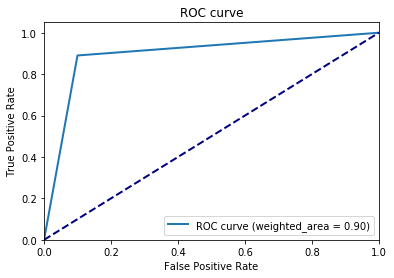

In [86]:
get_ensemble_predictions(LinearSVC(C=1.0, class_weight='balanced', dual=True, fit_intercept=True,
     intercept_scaling=1, loss='hinge', max_iter=1000, multi_class='ovr',
     penalty='l2', random_state=None, tol=1e-05, verbose=0)) #standard scaler
# 0.340506673930809
# 0.8892853889992015
# 0.8892853889992016
# 0.8632596685082873
# 0.21208008143875126
# 0.915311109490116

In [0]:
get_ensemble_predictions(LinearSVC(C=1.0, class_weight='balanced', dual=True, fit_intercept=True,
     intercept_scaling=1, loss='hinge', max_iter=20000, multi_class='ovr',
     penalty='l2', random_state=None, tol=1e-05, verbose=0)) #standard scaler + norm
# 0.24508050089445438
# 0.8968207662103654
# 0.8968207662103655
# 0.9461325966850829
# 0.14077270859021784
# 0.8475089357356481

In [0]:
get_ensemble_predictions(LinearSVC(C=1.0, class_weight='balanced', dual=True, fit_intercept=True,
     intercept_scaling=1, loss='hinge', max_iter=15000, multi_class='ovr',
     penalty='l2', random_state=None, tol=1e-05, verbose=0)) #standard scaler
# 0.34023991275899673
# 0.8886312536547954
# 0.8886312536547956
# 0.861878453038674
# 0.21195652173913043
# 0.915384054270917

In [76]:
get_ensemble_predictions(LinearSVC(C=1.0, class_weight='balanced', dual=True, fit_intercept=True,
     intercept_scaling=1, loss='hinge', max_iter=15000, multi_class='ovr',
     penalty='l2', random_state=None, tol=1e-05, verbose=0)) #standard scaler + norm
# 0.24508050089445438
# 0.8968207662103654
# 0.8968207662103655
# 0.9461325966850829
# 0.14077270859021784
# 0.8475089357356481

# 0.29390681003584235
# 0.7038273952484633
# 0.7038273952484633
# 0.45054945054945056
# 0.21808510638297873
# 0.9571053399474759

0.29390681003584235
0.7038273952484633
0.7038273952484633
0.45054945054945056
0.21808510638297873
0.9571053399474759


In [0]:
get_ensemble_predictions(LogisticRegression(solver='warn',C=100, class_weight=None, dual=False,
                                            fit_intercept=True,
          intercept_scaling=1, max_iter=5000, multi_class='warn',
          penalty='l2', random_state=None, tol=0.0001,
          verbose=0, warm_start=False)) # standard+norm
# 0.2508287292817679
# 0.8969031817223754
# 0.8969031817223754
# 0.9406077348066298
# 0.14470888227794304
# 0.8531986286381209


# 0.3611738148984198
# 0.8998755840016417
# 0.8998755840016417
# 0.8791208791208791
# 0.22727272727272727
# 0.9206302888824044

In [22]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import ParameterGrid
import parfit.parfit as pf
grid = {
    'C': [ 1e-6,  1e-3, 1e-2, 1e-1, 1e0, 10, 100],
    'penalty': ['l2'],
    'solver':['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'],
    'max_iter': [1000, 5000, 10000],
    'class_weight':['balanced', None],
    'tol': [1e-4, 1e-5, 1e-2, 1e-1, 1, 10]
}

dataset = pd.concat([positives, frames[0]], axis=0)
paramGrid = ParameterGrid(grid)
bestModel, bestScore, allModels, allScores = pf.bestFit(LogisticRegression, paramGrid,
           dataset[dataset.columns[:-1]], dataset[dataset.columns[-1]], X_test, Y_test, 
           metric = f1_score,
           greater_is_better=True,
           scoreLabel = "F1")
print(bestModel, bestScore)

-------------FITTING MODELS-------------


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    2.2s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:    2.4s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    2.6s
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:    2.7s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.1970s.) Setting batch_size=2.
[Parallel(n_jobs=-1)]: Done  21 tasks      | elapsed:    3.0s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.1438s.) Setting batch_size=4.
[Parallel(n_jobs=-1)]: Done  38 tasks      | elapsed:    3.5s
[Parallel(n_jobs=-1)]: Done  74 tasks      | elapsed:    4.7s
[Parallel(n_jobs=-1)]: Done 110 tasks      | elapsed:    5.9s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:    7.4s
[Parallel(n_jobs=-1)]: Done 198 tasks      | elapsed:    8.8s
[Parallel(n_jobs=-1)]: Done 250 tasks      | elapsed:   11.1s
[Parallel(n_jobs=-1)]: Done 302 tasks      | elapsed:   13.3s
[Parallel(n_jo

-------------SCORING MODELS-------------


[Parallel(n_jobs=-1)]: Done  88 tasks      | elapsed:    3.7s
[Parallel(n_jobs=-1)]: Done 388 tasks      | elapsed:   16.2s
[Parallel(n_jobs=-1)]: Done 888 tasks      | elapsed:   36.8s


Too many dimensions to plot.
LogisticRegression(C=10, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=10000,
          multi_class='warn', n_jobs=None, penalty='l2', random_state=None,
          solver='sag', tol=10, verbose=0, warm_start=False) 0.3925155925155925


[Parallel(n_jobs=-1)]: Done 1260 out of 1260 | elapsed:   52.5s finished


In [59]:

get_ensemble_predictions(LogisticRegression(C=10, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=10000,
          multi_class='warn', n_jobs=None, penalty='l2', random_state=None,
          solver='sag', tol=10, verbose=0, warm_start=False))# 0.3925155925155925

0.21349693251533744
0.8850835479081759
0.8850835479081759
0.9560439560439561
0.12016574585635359
0.8141231397723957
